# Parking_Demand_Predict

[주차수요 예측 AI 경진대회](https://dacon.io/competitions/official/235745/overview/description)

# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:.4f}'.format
data_path = "./data/"
train_file = f"{data_path}train.csv"
test_file = f"{data_path}test.csv"
sample_submit_file = f"{data_path}sample_submission.csv"

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load Data

In [3]:
train = reduce_mem_usage(pd.read_csv(train_file))
test = reduce_mem_usage(pd.read_csv(test_file))

print(train.shape, test.shape)
print(set(train.columns) - set(test.columns))

Mem. usage decreased to  0.20 Mb (40.0% reduction)
Mem. usage decreased to  0.07 Mb (37.5% reduction)
(2952, 15) (1022, 14)
{'등록차량수'}


In [4]:
label = "등록차량수"

In [5]:
# 에러 데이터 제거

error_data = ['C2085', 'C1397', 'C2431', 'C1649', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']

for error in error_data:
    error_index = train[train['단지코드'] == error].index
    train.drop(error_index, inplace=True)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2876 non-null   object 
 1   총세대수                          2876 non-null   int16  
 2   임대건물구분                        2876 non-null   object 
 3   지역                            2876 non-null   object 
 4   공급유형                          2876 non-null   object 
 5   전용면적                          2876 non-null   float16
 6   전용면적별세대수                      2876 non-null   int16  
 7   공가수                           2876 non-null   float16
 8   자격유형                          2876 non-null   object 
 9   임대보증금                         2307 non-null   object 
 10  임대료                           2307 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2669 non-null   float16
 12  도보 10분거리 내 버스정류장 수            2876 non-null   float16
 13  단지내

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          1022 non-null   object 
 1   총세대수                          1022 non-null   int16  
 2   임대건물구분                        1022 non-null   object 
 3   지역                            1022 non-null   object 
 4   공급유형                          1022 non-null   object 
 5   전용면적                          1022 non-null   float16
 6   전용면적별세대수                      1022 non-null   int16  
 7   공가수                           1022 non-null   float16
 8   자격유형                          1020 non-null   object 
 9   임대보증금                         842 non-null    object 
 10  임대료                           842 non-null    object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  980 non-null    float16
 12  도보 10분거리 내 버스정류장 수            1022 non-null   float16
 13  단지내

## 탐색

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2876 non-null   object 
 1   총세대수                          2876 non-null   int16  
 2   임대건물구분                        2876 non-null   object 
 3   지역                            2876 non-null   object 
 4   공급유형                          2876 non-null   object 
 5   전용면적                          2876 non-null   float16
 6   전용면적별세대수                      2876 non-null   int16  
 7   공가수                           2876 non-null   float16
 8   자격유형                          2876 non-null   object 
 9   임대보증금                         2307 non-null   object 
 10  임대료                           2307 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2669 non-null   float16
 12  도보 10분거리 내 버스정류장 수            2876 non-null   float16
 13  단지내

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,2876.0000,887.2997,517.2142,26.0000,514.0000,775.0000,1100.5000,2568.0000
전용면적,2876.0000,inf,inf,12.6172,32.0938,39.8438,51.0703,583.5000
전용면적별세대수,2876.0000,102.7079,133.1522,1.0000,14.0000,60.0000,142.2500,1865.0000
공가수,2876.0000,12.9141,10.6719,0.0000,4.0000,11.0000,20.0000,55.0000
도보 10분거리 내 지하철역 수(환승노선 수 반영),2669.0000,0.1814,0.4321,0.0000,0.0000,0.0000,0.0000,3.0000
도보 10분거리 내 버스정류장 수,2876.0000,3.7070,2.6738,0.0000,2.0000,3.0000,4.0000,20.0000
단지내주차면수,2876.0000,inf,inf,13.0000,277.0000,502.0000,813.2500,1798.0000
등록차량수,2876.0000,inf,inf,13.0000,209.0000,480.0000,762.0000,2550.0000


In [10]:
train.describe(include="O").T

,count,unique,top,freq
단지코드,2876,412,C1439,48
임대건물구분,2876,2,아파트,2314
지역,2876,16,경기도,602
공급유형,2876,10,국민임대,1734
자격유형,2876,15,A,1736
임대보증금,2307,926,24775000,22
임대료,2307,965,390000,19


array([[<AxesSubplot:title={'center':'총세대수'}>,
        <AxesSubplot:title={'center':'전용면적'}>,
        <AxesSubplot:title={'center':'전용면적별세대수'}>],
       [<AxesSubplot:title={'center':'공가수'}>,
        <AxesSubplot:title={'center':'도보 10분거리 내 지하철역 수(환승노선 수 반영)'}>,
        <AxesSubplot:title={'center':'도보 10분거리 내 버스정류장 수'}>],
       [<AxesSubplot:title={'center':'단지내주차면수'}>,
        <AxesSubplot:title={'center':'등록차량수'}>, <AxesSubplot:>]],
      dtype=object)

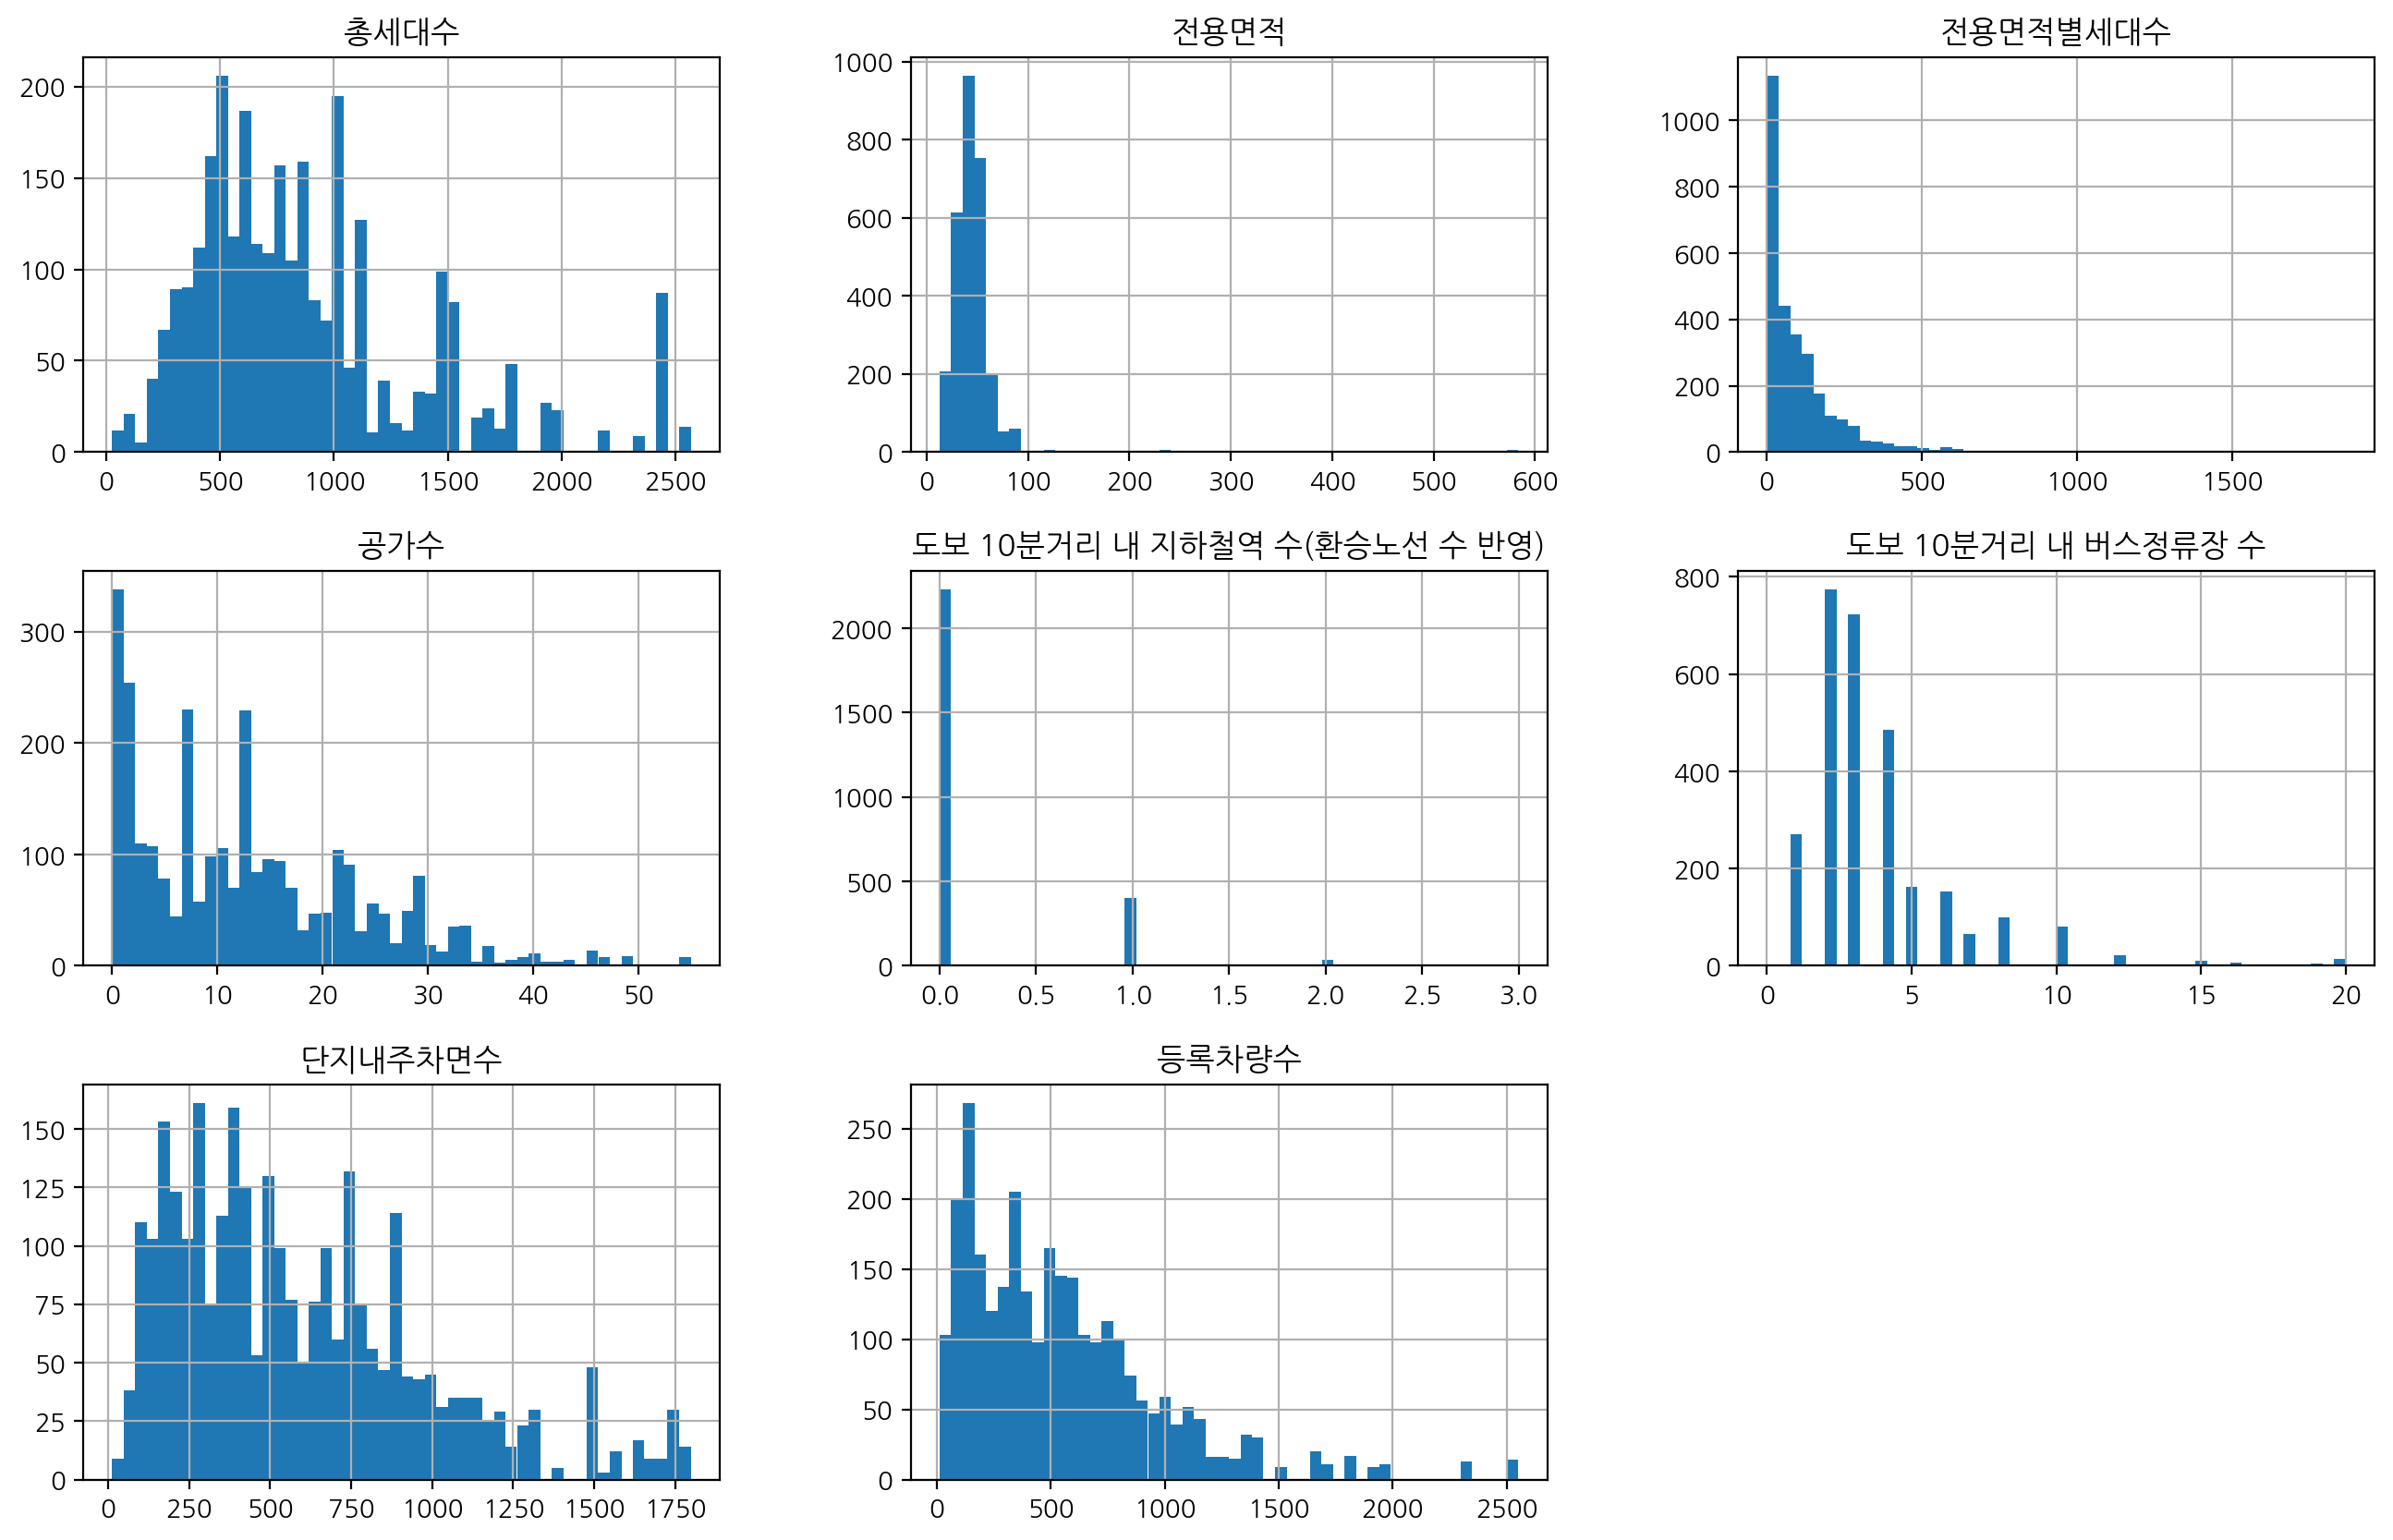

In [11]:
train.hist(figsize=(16,10), bins=50)

# Preprocessing

## 결측치

In [12]:
display(train.isnull().sum())

display(test.isnull().sum())

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     42
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [13]:
train[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]] = (
    train[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]]
    .fillna(0)
    .astype(np.uint8)
)
train["임대보증금"] = train["임대보증금"].replace("-", 0)
train["임대료"] = train["임대료"].replace("-", 0)
train[["임대보증금", "임대료"]] = train[["임대보증금", "임대료"]].fillna(0).astype(np.uint64)
display(train.isnull().sum())

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            0
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
등록차량수                           0
dtype: int64

In [14]:
train[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]] = (
    train[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]]
    .fillna(0)
    .astype(np.uint8)
)
train["임대보증금"] = train["임대보증금"].replace("-", 0)
train["임대료"] = train["임대료"].replace("-", 0)
train[["임대보증금", "임대료"]] = train[["임대보증금", "임대료"]].fillna(0).astype(np.uint64)
display(train.isnull().sum())

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            0
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
등록차량수                           0
dtype: int64

## 스케일링

In [44]:
print(train.drop(columns="등록차량수").describe().T.index.to_list())
scailing_features = train.drop(columns="등록차량수").describe().T.index.to_list()

['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수']


In [45]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

train[scailing_features] = scaler.fit_transform(train[scailing_features])
display(train[scailing_features])

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
8,-0.3922,-0.3359,1.6842,0.3750,-0.4304,-0.3892,0.0000,0.0000,0.2275
9,-0.3922,-0.0132,0.0000,0.3750,-0.2476,-0.2066,0.0000,0.0000,0.2275
10,-0.3922,-0.0132,-0.3119,0.3750,-0.2476,-0.2066,0.0000,0.0000,0.2275
11,-0.3922,0.3722,-0.1715,0.3750,0.0572,0.1153,0.0000,0.0000,0.2275
12,-0.3922,0.3722,-0.3197,0.3750,0.0572,0.1153,0.0000,0.0000,0.2275
...,...,...,...,...,...,...,...,...,...
2947,-0.9139,0.4924,-0.3197,-0.2500,-0.3178,-0.1389,0.0000,-1.0000,-0.6266
2948,-0.9139,0.5928,-0.2027,-0.2500,-0.1771,0.0590,0.0000,-1.0000,-0.6266
2949,-0.9139,0.6258,-0.2027,-0.2500,-0.1771,0.0590,0.0000,-1.0000,-0.6266
2950,-0.9139,0.6389,0.4211,-0.2500,-0.1771,0.0590,0.0000,-1.0000,-0.6266


## 인코딩

# corr

In [20]:
corr = pd.DataFrame(train.drop(columns = label).corrwith(train[label]))
corr_sort_abs = corr.sort_values(by=0, ascending=0, key=abs)
display(corr_sort_abs)

,0
단지내주차면수,0.8568
임대료,0.5307
임대보증금,0.4140
총세대수,0.3246
전용면적별세대수,0.2541
공가수,0.1303
도보 10분거리 내 버스정류장 수,0.1095
전용면적,0.1063
도보 10분거리 내 지하철역 수(환승노선 수 반영),-0.0809


In [21]:
corr_high = corr.loc[np.abs(corr_sort_abs[0]) > 0.1]
display(corr_high)
print(len(corr_high.index.to_list()))

,0
총세대수,0.3246
전용면적,0.1063
전용면적별세대수,0.2541
공가수,0.1303
임대보증금,0.4140
임대료,0.5307
도보 10분거리 내 버스정류장 수,0.1095
단지내주차면수,0.8568


8


<AxesSubplot:>

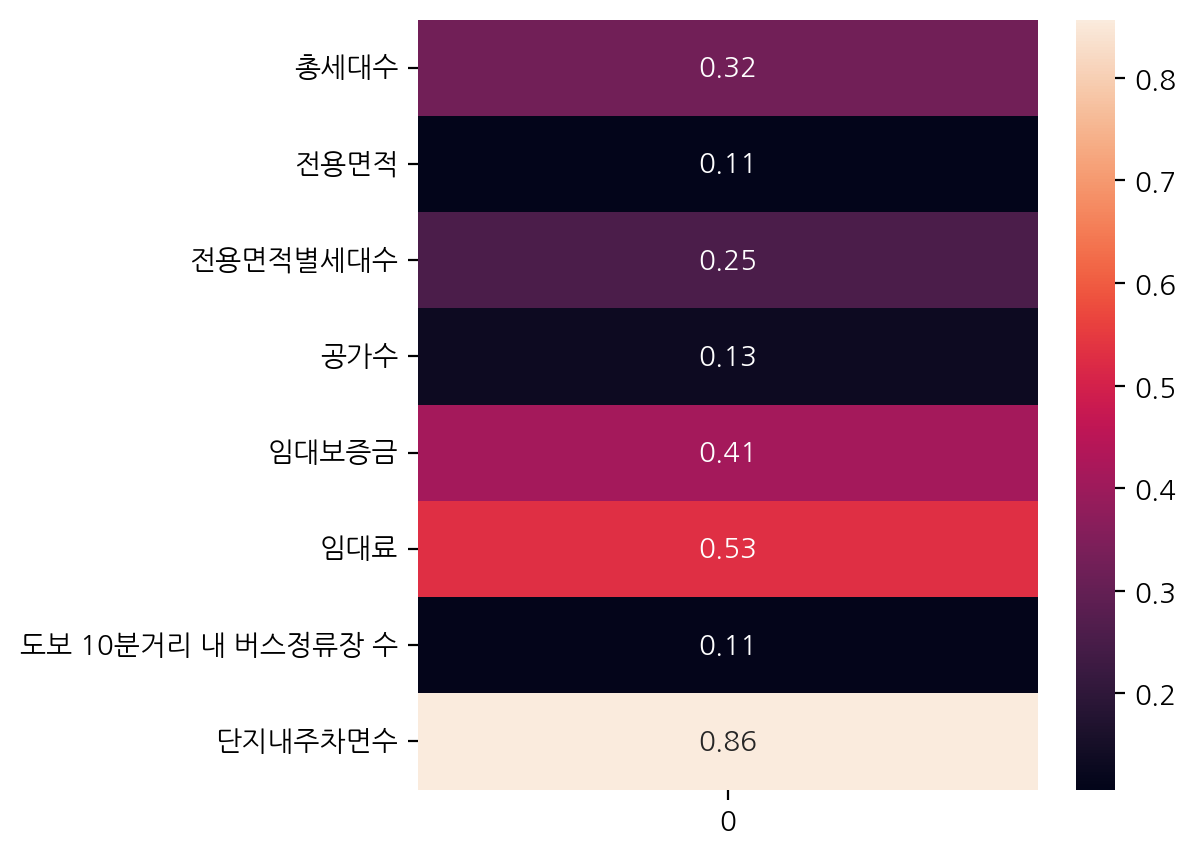

In [22]:
plt.figure(figsize = (5, 5))
sns.heatmap(data = corr_high, annot = True, fmt = '.2f')

# ML

## Dataset

In [24]:
features = corr_high.index.to_list()
print(label)
print(features)

등록차량수
['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '도보 10분거리 내 버스정류장 수', '단지내주차면수']


In [26]:
X_train = train[features]
y_train = train[label]

X_train.shape, y_train.shape

((2876, 8), (2876,))

In [28]:
X_test = test[features]

X_test.shape

(1022, 8)

## model

In [29]:
from sklearn.linear_model import Lasso

lasso = Lasso()

## val

In [46]:
from sklearn.model_selection import cross_val_predict

y_valid_pred = cross_val_predict(lasso, X_train, y_train, cv=5, n_jobs=-1, verbose=2)
y_valid_pred

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


array([535.617817  , 532.77307145, 528.84293797, ..., 227.04821958,
       229.14979514, 230.8274726 ])

In [47]:
mse = np.square(y_train - y_valid_pred).mean()
rmse = np.sqrt(mse)
rmse

228.90363186748374

<AxesSubplot:xlabel='등록차량수'>

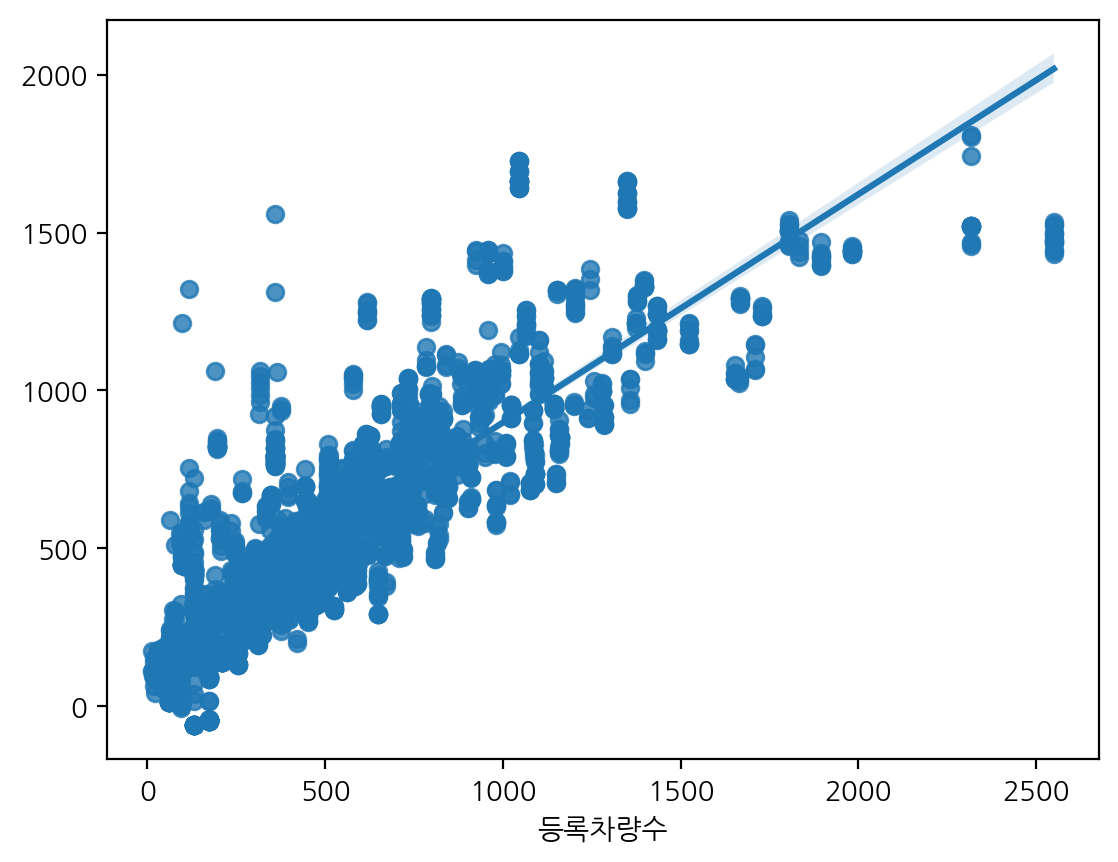

In [48]:
sns.regplot(x=y_train, y=y_valid_pred)

In [49]:
from sklearn.metrics import r2_score

r2_score(y_train, y_valid_pred)

c:\Users\sacer\anaconda3\envs\AIS7\lib\site-packages\sklearn\metrics\_regression.py:807: RuntimeWarning: overflow encountered in square
  weight * (y_true - np.average(y_true, axis=0, weights=sample_weight)) ** 2


1.0

<AxesSubplot:xlabel='등록차량수', ylabel='Density'>

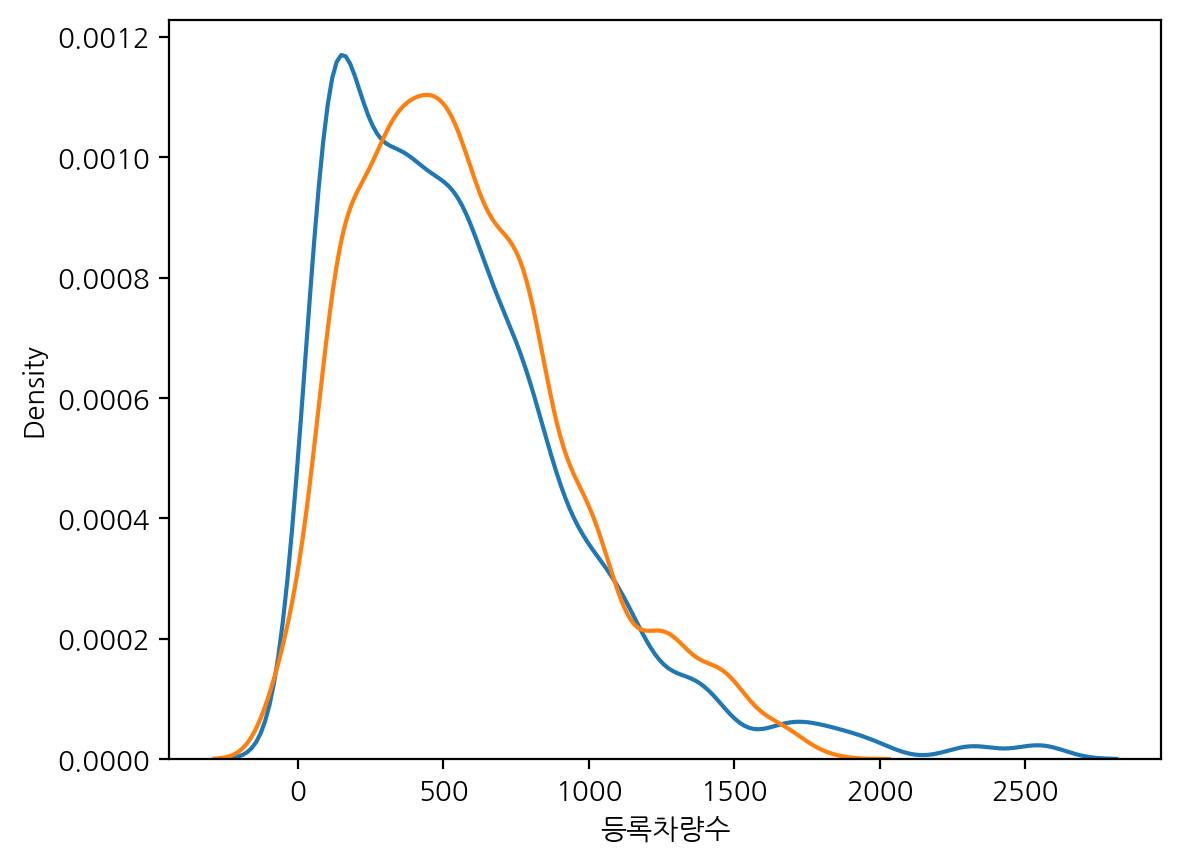

In [50]:
sns.kdeplot(y_train)
sns.kdeplot(y_valid_pred)

In [52]:
y_predict = lasso.fit(X_train, y_train).predict(X_test)
y_predict

ValueError: could not convert string to float: '-'

In [ ]:
fi = pd.Series(model.feature_importances_)
fi.index = model.feature_names_in_
fi.nlargest(20)

In [ ]:
fi.nlargest(20).plot.barh()